# Econ 412 Project 1
## Leonardo Livio Fancello, Korntawat Yodkhan, Stephen Lin and Hayden Johnson

## Introduction

Our dataset comes from Kaggle and it measures the average land temperature of the earth from 1750 to 2015. Each recorded temperature is the average temperature for the month, which most likely will show some seasonality as the average temperature should increase in the summer months and decrease in the winter months. We chose to stick with data from 1900 to 2015 because there were some missing observations that we could not forward fill without compromising our forecast. 115 years worth of monthly data is still enough to get an accurate forecast. We chose this dataset because we are interested in climate change and how the earths temperature has been affected by the industrial revolution.

In [1]:
import pandas as pd
import numpy as np
import itertools

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
plt.style.use('seaborn-white')
%matplotlib inline

#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
import statsmodels.formula.api as smf
#from nimbusml.timeseries import SsaForecaster
from statsmodels.tsa.statespace.tools import diff as diff
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")
np.random.seed(123)

In [2]:
clim = pd.read_csv('GlobalTemperatures.csv', parse_dates = True, index_col = 0)
clim = clim[['LandAverageTemperature']]
clim

,LandAverageTemperature
dt,
1750-01-01,3.034
1750-02-01,3.083
1750-03-01,5.626
1750-04-01,8.490
1750-05-01,11.573
...,...
2015-08-01,14.755
2015-09-01,12.999
2015-10-01,10.801


In [3]:
clim = clim[clim.index >=  '1900-01-01']
clim

,LandAverageTemperature
dt,
1900-01-01,1.461
1900-02-01,3.098
1900-03-01,5.492
1900-04-01,8.223
1900-05-01,11.385
...,...
2015-08-01,14.755
2015-09-01,12.999
2015-10-01,10.801


### 1.a - Plot the Series

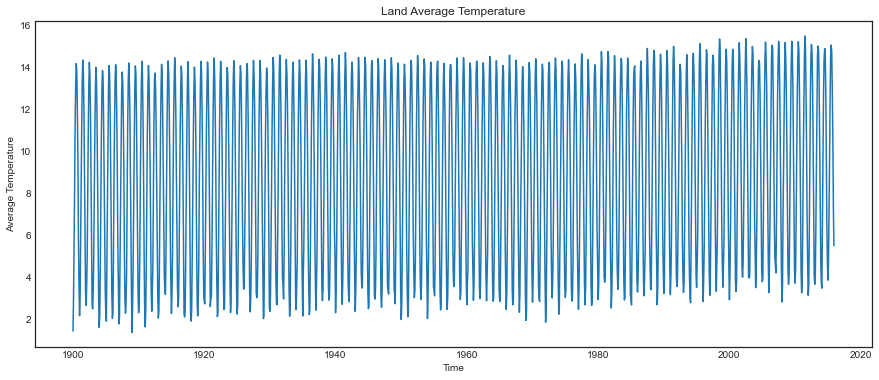

In [4]:
plt.figure(figsize=(15,6))
plt.plot(clim.LandAverageTemperature)
plt.title('Land Average Temperature')
plt.xlabel('Time')
plt.ylabel('Average Temperature')
plt.show()

### 1.b - Covariance Stationary

In [5]:
adf = adfuller(clim["LandAverageTemperature"])[1]
print(f"p value:{adf}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary.")

p value:0.8490736220824071 , Series is Non-Stationary.


The series is not covariance, mean and variance stationary according to the adf. You can see from the plot as well that the variance is not constant from 1900 to 2015.

### 1.c - ACF and PACF

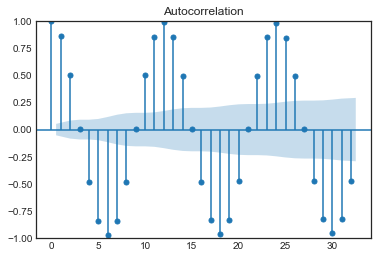

In [7]:
plot_acf(clim);

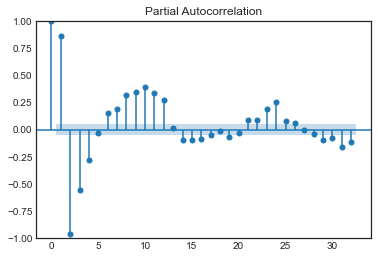

In [8]:
plot_pacf(clim);

From the graphs we can see that the nodes are not within the boundary, indicating that we should investigate further.

### 1.d - Models

In [9]:
clim['counter'] = np.arange(len(clim))

In [10]:
clim['t'] = np.arange(1, len(clim)+1)

In [11]:
clim['Month'] = clim.index.month_name()

In [12]:
# Suppose we start at time t = 200
# we can estimate our model on the first 200 observations
lmodel = smf.ols('LandAverageTemperature ~ t', clim).fit()

lmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     LandAverageTemperature   R-squared:                       0.008
Model:                                OLS   Adj. R-squared:                  0.007
Method:                     Least Squares   F-statistic:                     10.75
Date:                    Mon, 24 Apr 2023   Prob (F-statistic):            0.00107
Time:                            23:32:25   Log-Likelihood:                -3966.9
No. Observations:                    1392   AIC:                             7938.
Df Residuals:                        1390   BIC:                             7948.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1251      0.224     36.196      0.000       7.685       8.565
t              0.0009      0.000      3.278      0.001       0.000       0.001
==============================================================================
Omnibus:                     9718.933   Durbin-Watson:                   0.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.420
Skew:                          -0.071   Prob(JB):                     4.78e-29
Kurtosis:                       1.507   Cond. No.                     1.61e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
nlmodel = smf.ols('LandAverageTemperature ~ t + I(t**2)', clim).fit()
nlmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     LandAverageTemperature   R-squared:                       0.008
Model:                                OLS   Adj. R-squared:                  0.007
Method:                     Least Squares   F-statistic:                     5.776
Date:                    Mon, 24 Apr 2023   Prob (F-statistic):            0.00318
Time:                            23:32:26   Log-Likelihood:                -3966.5
No. Observations:                    1392   AIC:                             7939.
Df Residuals:                        1389   BIC:                             7955.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3512      0.337     24.778      0.000       7.690       9.012
t          -5.804e-05      0.001     -0.052      0.959      -0.002       0.002
I(t ** 2)   6.986e-07   7.77e-07      0.899      0.369   -8.25e-07    2.22e-06
==============================================================================
Omnibus:                     9686.811   Durbin-Watson:                   0.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.610
Skew:                          -0.071   Prob(JB):                     4.35e-29
Kurtosis:                       1.506   Cond. No.                     2.61e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'Avergae Temperature')

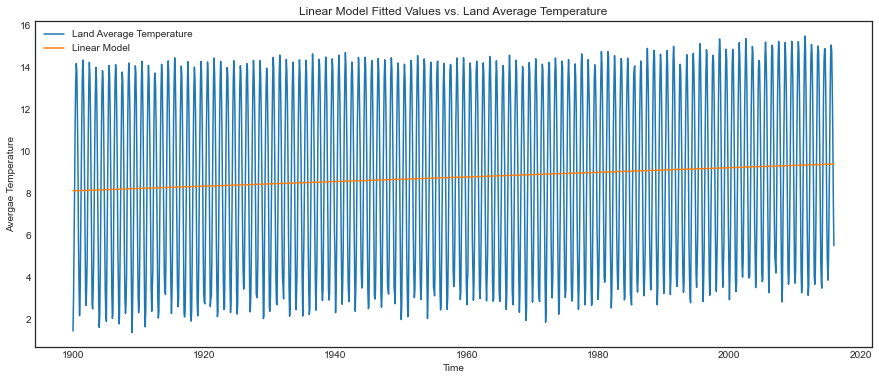

In [14]:
plt.figure(figsize=(15,6))
plt.title('Linear Model Fitted Values vs. Land Average Temperature')
plt.plot(clim.LandAverageTemperature, label = 'Land Average Temperature')
plt.plot(lmodel.fittedvalues, label = 'Linear Model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Avergae Temperature')

Text(0, 0.5, 'Avergae Temperature')

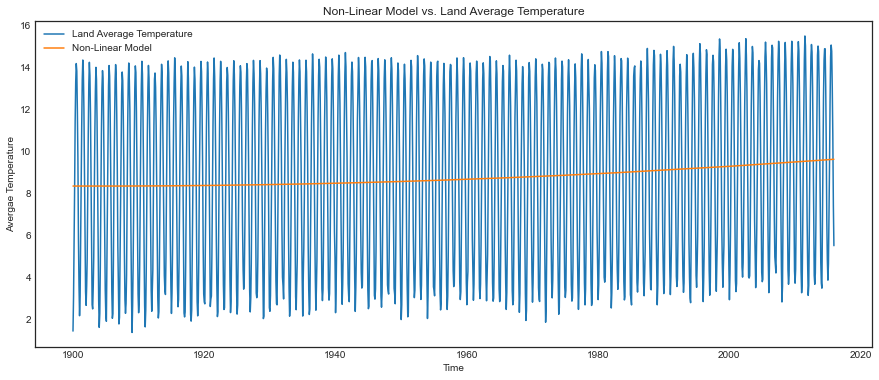

In [15]:
plt.figure(figsize=(15,6))
plt.title('Non-Linear Model vs. Land Average Temperature')
plt.plot(clim.LandAverageTemperature, label = 'Land Average Temperature')
plt.plot(nlmodel.fittedvalues, label = 'Non-Linear Model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Avergae Temperature')

### 1.e - Residuals VS Fitted Values

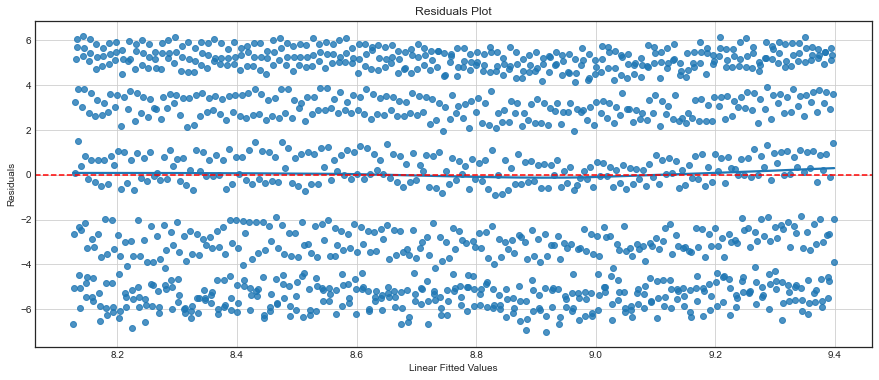

In [16]:
plt.figure(figsize = (15, 6))
sns.regplot(x = lmodel.fittedvalues, y = lmodel.resid, lowess = True)
plt.axhline(0, linestyle = '--', color = "red")
plt.ylabel("Residuals")
plt.xlabel("Linear Fitted Values")
plt.title("Residuals Plot")
plt.grid()
plt.show()

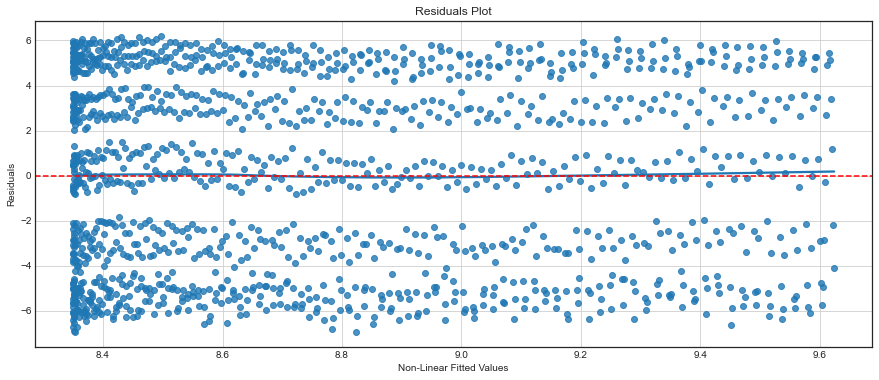

In [17]:
plt.figure(figsize = (15, 6))
sns.regplot(x = nlmodel.fittedvalues, y = nlmodel.resid, lowess = True)
plt.axhline(0, linestyle = '--', color = "red")
plt.ylabel("Residuals")
plt.xlabel("Non-Linear Fitted Values")
plt.title("Residuals Plot")
plt.grid()
plt.show()

Both graphs have definite clusters across the fitted values. The lower level of fitted values contain more observations for the non-linear model, and the linear model sees the observations spread out across the fitted values. Both models appear to be centered around zero.

### 1.f - Residuals Histogram

Text(0, 0.5, 'Frequency')

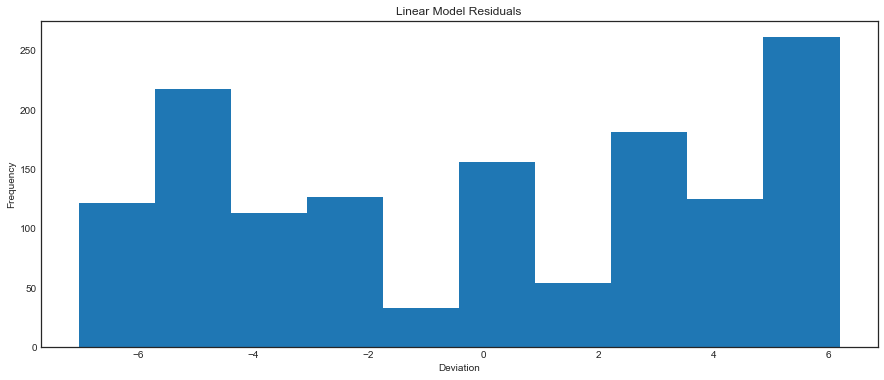

In [18]:
plt.figure(figsize=(15,6))
plt.title('Linear Model Residuals')
plt.hist(lmodel.resid)
plt.xlabel('Deviation')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

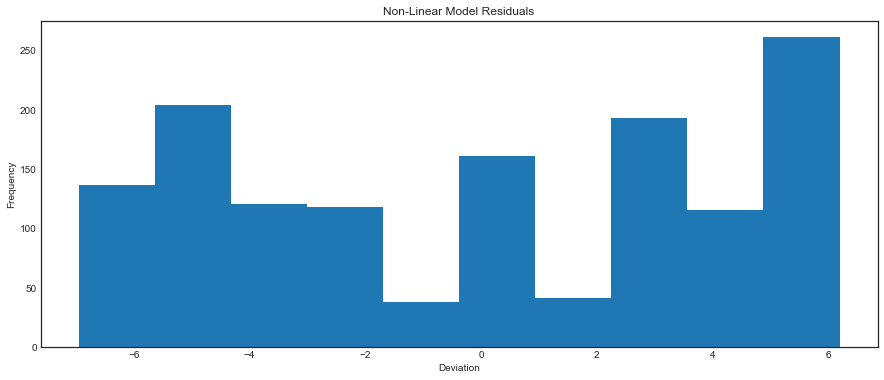

In [19]:
plt.figure(figsize=(15,6))
plt.title('Non-Linear Model Residuals')
plt.hist(nlmodel.resid)
plt.xlabel('Deviation')
plt.ylabel('Frequency')

Both models do not have a definite distribution. There is no resemblance of a normal distribution in either one of them. They are random.

### 1.g - Diagnostic Statistics

**Linear Model**

The adjusted R^2 is 0.007 and the R^2 are 0.008. These numbers are not good, indicating the independent variables do not explain the variance of the dependent variable very well. T is statistically significant, indicating the trend has a impact on forecasting future average temperatures. The t-distribution is large. The F-statistic is close to 0, so it is jointly significant. Skewness is -0.071 with kurtosis of 1.507 and a large Jarque Bera test, so the linear model is not normally distributed.

**Non-Linear Model**

The adjusted R^2 is 0.007 and the R^2 is 0.008 so the independent variables do not explain the variation in the dependent variable very well. Neither the trend, t, nor the quadratic term, t^2, is significant. This means they do not have a large impact on forecasting future average temperatures. The F-statistic is close to 0, meaning the ts are jointly singificant together. The skew is -0.071 and kurtosis is 1.506. The Jarque Bera test is large, indicating the non-linear model is not normal either. The t-distributions for both parameters were very small.

### 1.h - AIC and BIC

In [20]:
print("The AIC for the linear model:", lmodel.aic)
print("The BIC for the linear model:", lmodel.bic)

The AIC for the linear model: 7937.852908165163
The BIC for the linear model: 7948.3299018469515


In [21]:
print("The AIC for the non-linear model:", nlmodel.aic)
print("The BIC for the non-linear model:", nlmodel.bic)

The AIC for the non-linear model: 7939.042573539236
The BIC for the non-linear model: 7954.75806406192


The linear model is the best model according to AIC and BIC, so yes they agree. It is the best because the AIC and BIC are lowest for between the linear and non-linear model.

### 1.i - Forecasting

In [22]:
clim.index

DatetimeIndex(['1900-01-01', '1900-02-01', '1900-03-01', '1900-04-01',
               '1900-05-01', '1900-06-01', '1900-07-01', '1900-08-01',
               '1900-09-01', '1900-10-01',
               ...
               '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
               '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', name='dt', length=1392, freq=None)

In [23]:
# extract the starting date and the end dat for my forecast horizon
dates = pd.date_range(start = '2016-01-01', end = '2018-01-01', freq = 'MS')

# get the names of each month for the forecast horizon
month = dates.month_name()

# get the trend variable for the forecast horizon, starting at the end of the original
t = np.arange(len(clim['LandAverageTemperature']), len(clim['LandAverageTemperature'])+25)

# put into a format accepted by statsmodels
new = pd.DataFrame({'Month': month, 't':t, 'AverageTemperature' :np.ones(len(month))}, index = dates)

In [24]:
new

,Month,t,AverageTemperature
2016-01-01,January,1392,1.0
2016-02-01,February,1393,1.0
2016-03-01,March,1394,1.0
2016-04-01,April,1395,1.0
2016-05-01,May,1396,1.0
2016-06-01,June,1397,1.0
2016-07-01,July,1398,1.0
2016-08-01,August,1399,1.0
2016-09-01,September,1400,1.0
2016-10-01,October,1401,1.0


In [25]:
forecast = lmodel.get_prediction(new).summary_frame(alpha=0.1).set_index(dates)
forecast

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
2016-01-01,9.398905,0.224236,9.029824,9.767986,2.500190,16.297620
2016-02-01,9.399820,0.224478,9.030341,9.769299,2.501084,16.298556
2016-03-01,9.400735,0.224720,9.030858,9.770613,2.501978,16.299493
2016-04-01,9.401650,0.224962,9.031375,9.771926,2.502872,16.300429
2016-05-01,9.402565,0.225204,9.031891,9.773239,2.503765,16.301366
2016-06-01,9.403481,0.225446,9.032408,9.774553,2.504659,16.302302
2016-07-01,9.404396,0.225688,9.032924,9.775867,2.505553,16.303239
2016-08-01,9.405311,0.225930,9.033441,9.777181,2.506446,16.304175
2016-09-01,9.406226,0.226173,9.033957,9.778495,2.507340,16.305112
2016-10-01,9.407141,0.226415,9.034473,9.779809,2.508233,16.306048


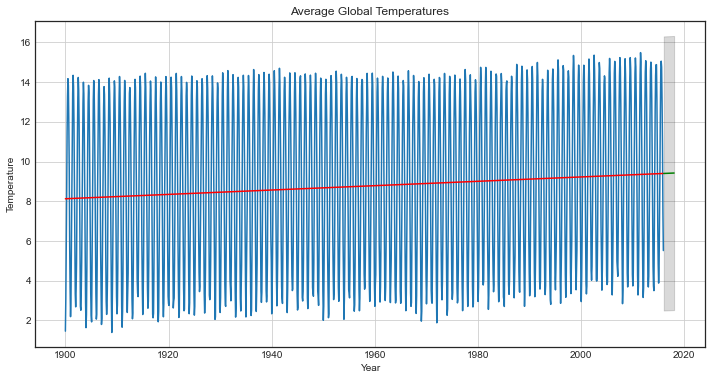

In [26]:
plt.figure(figsize = (12, 6))
plt.title('Average Global Temperatures')
plt.plot(clim['LandAverageTemperature'])
plt.plot(lmodel.fittedvalues, color='r',label='Linear Model')
plt.plot(forecast['mean'], color='g', label='Forecast')
plt.fill_between(forecast.index, forecast.obs_ci_lower, forecast.obs_ci_upper, color='k',alpha=.15)

plt.xlabel('Year')
plt.ylabel('Temperature')
plt.grid()

## 2

### 2.a - Additive Decomposition

Text(0.5, 0.98, 'Additive Decomposition')

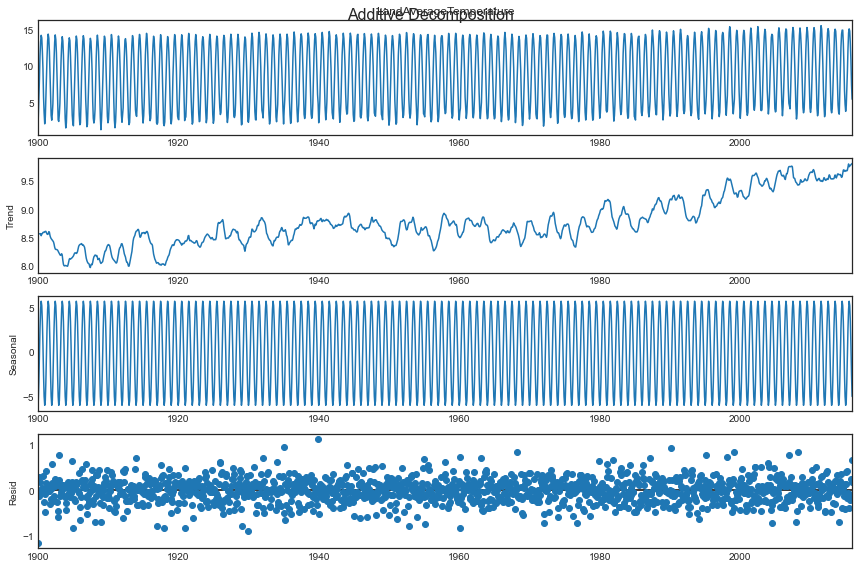

In [27]:
decomposeA = seasonal_decompose(clim["LandAverageTemperature"],model='additive', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (12, 8);
decomposeA.plot().suptitle('Additive Decomposition', fontsize=16)

In [28]:
df_reconstructed = pd.concat([decomposeA.seasonal, decomposeA.trend, decomposeA.resid, decomposeA.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
dt,,,,
1900-01-01,-5.942586,8.559768,-1.156182,1.461
1900-02-01,-5.427608,8.561479,-0.035871,3.098
1900-03-01,-3.363343,8.563189,0.292154,5.492
1900-04-01,-0.223055,8.564899,-0.118845,8.223
1900-05-01,2.633998,8.566610,0.184392,11.385


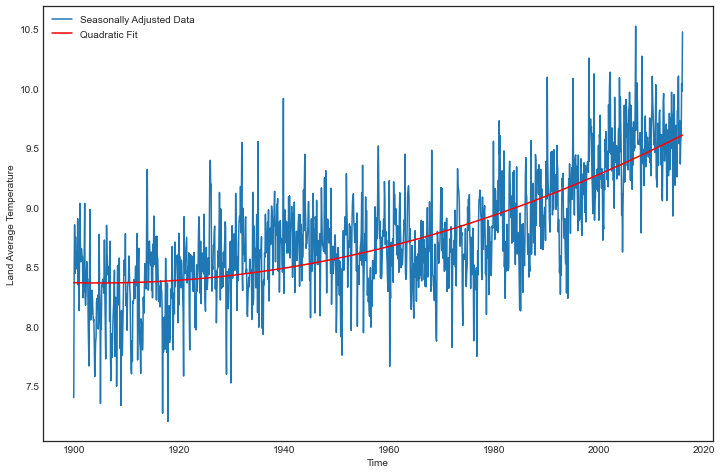

In [78]:
# Seasonally adjust the series
data_seasAdj = clim.LandAverageTemperature - decomposeA.seasonal

# Fit a quadratic trend
x_ts = clim.index
y_ts = data_seasAdj
n = np.shape(y_ts)[0]

# Quadratic Fit
t = range(n)
p = np.polyfit(t,y_ts,2)
y = np.polyval(p,t)
plt.plot(x_ts,y_ts,label='Seasonally Adjusted Data')
plt.plot(x_ts,y,color='r',label ='Quadratic Fit')
plt.xlabel('Time')
plt.ylabel('Land Average Temperature')
plt.legend()

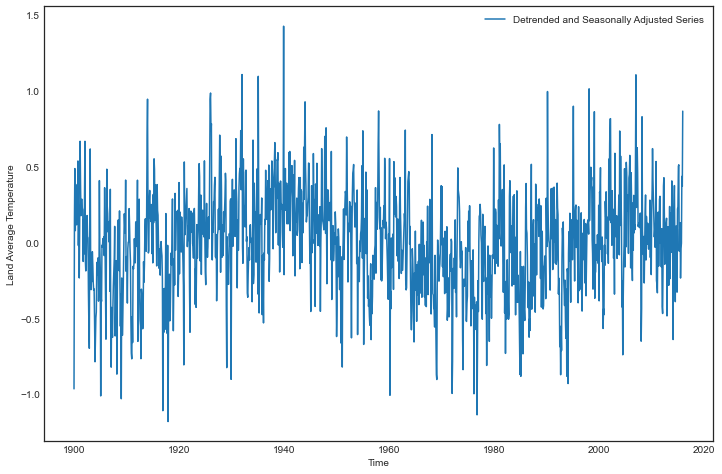

In [79]:
cycles = y_ts-y
plt.plot(x_ts,cycles,label='Detrended and Seasonally Adjusted Series')
plt.xlabel('Time')
plt.ylabel('Land Average Temperature')
plt.legend()

In [37]:
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot

<Figure size 720x576 with 0 Axes>

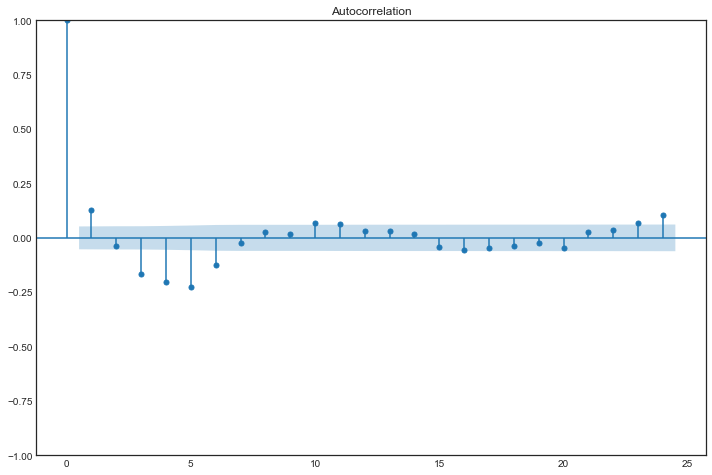

In [43]:
plt.figure(figsize =(10,8))
plot_acf(DecomposeA.resid,lags = 24)
plt.show()

<Figure size 720x576 with 0 Axes>

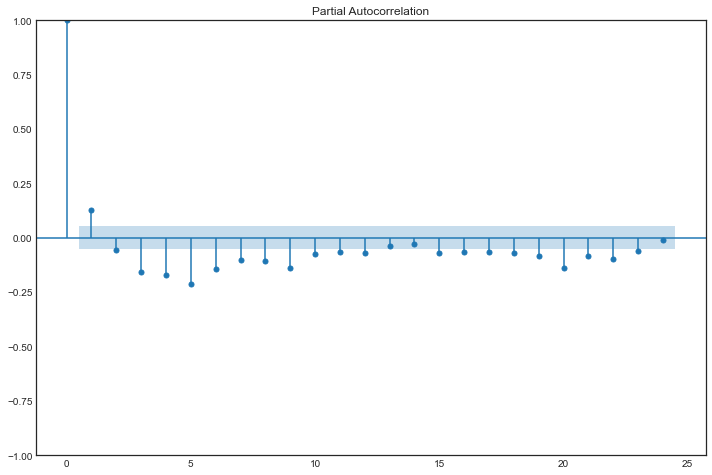

In [42]:
plt.figure(figsize =(10,8))
plot_pacf(DecomposeA.resid,lags = 24)
plt.show()

The ACF has spikes at 1, 3, 4, 5 and 6. The biggest spike is at 5 and it decays from there. The PACF displays nearly all the spikes being outside of the threshold. The PACF suggests there is a significant autocorrelation between the variable and its lagged values. The ACF indicates there may be a seasonal pattern or trend.

### 2.b - Multiplicative Decomposition

Text(0.5, 0.98, 'Multiplicative Decomposition')

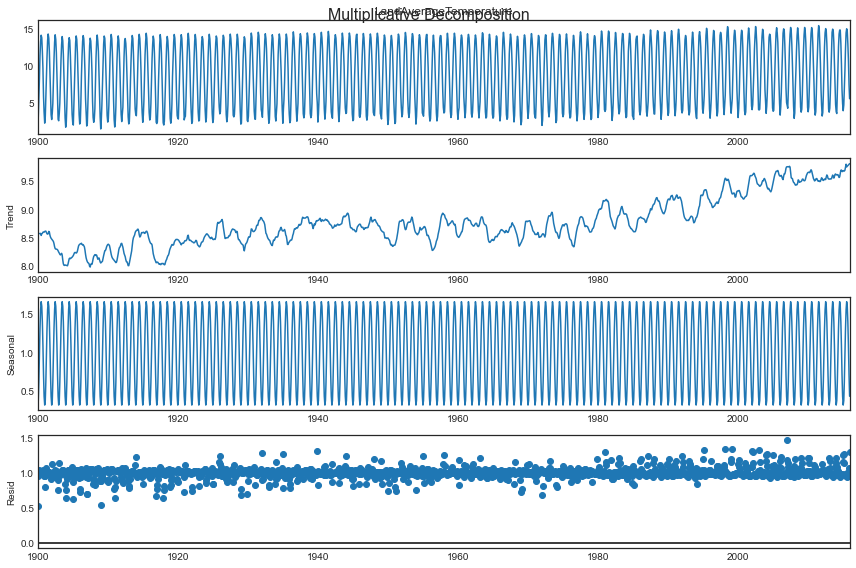

In [80]:
decomposeM = seasonal_decompose(clim["LandAverageTemperature"],model='multiplicative', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (12, 8);
decomposeM.plot().suptitle('Multiplicative Decomposition', fontsize=16)

In [81]:
df_reconstructed = pd.concat([decomposeM.seasonal, decomposeM.trend, decomposeM.resid, decomposeM.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
dt,,,,
1900-01-01,0.319573,8.559768,0.534094,1.461
1900-02-01,0.378399,8.561479,0.956274,3.098
1900-03-01,0.614649,8.563189,1.043441,5.492
1900-04-01,0.974360,8.564899,0.985345,8.223
1900-05-01,1.301508,8.566610,1.021121,11.385


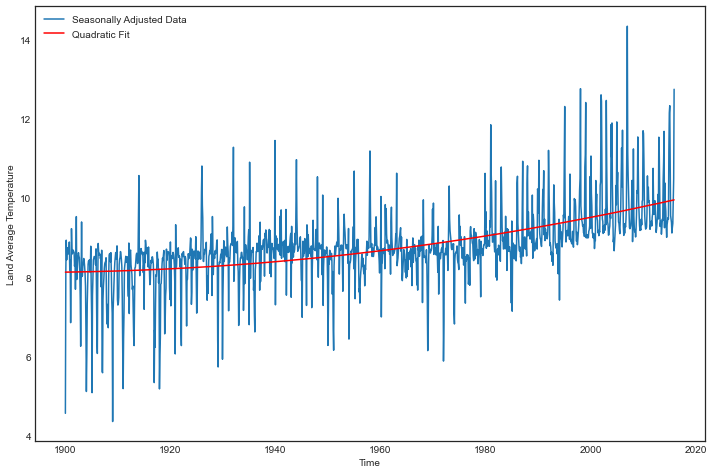

In [82]:
# Seasonally adjust the series
data_seasAdj = clim.LandAverageTemperature / decomposeM.seasonal

# Fit a quadratic trend
x_ts = clim.index
y_ts = data_seasAdj
n = np.shape(y_ts)[0]

# Quadratic Fit
t = range(n)
p = np.polyfit(t,y_ts,2)
y = np.polyval(p,t)
plt.plot(x_ts,y_ts,label='Seasonally Adjusted Data')
plt.plot(x_ts,y,color='r',label ='Quadratic Fit')
plt.xlabel('Time')
plt.ylabel('Land Average Temperature')
plt.legend()

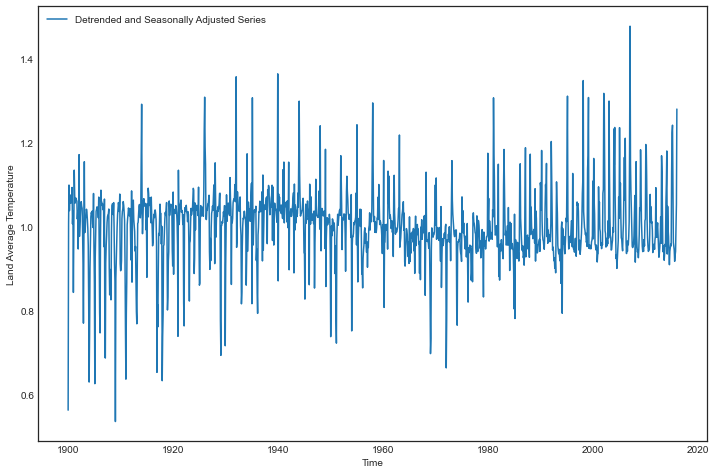

In [83]:
# Detrend Series and obtain the residuals (cycles)
cycles = y_ts/y
plt.plot(x_ts,cycles,label='Detrended and Seasonally Adjusted Series')
plt.xlabel('Time')
plt.ylabel('Land Average Temperature')
plt.legend()

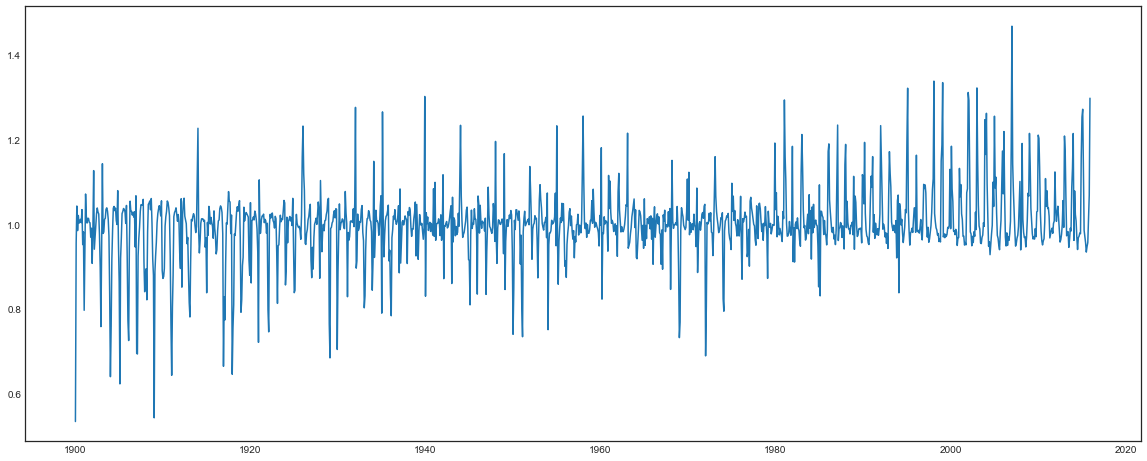

In [44]:
plt.figure(figsize = (20,8))
plt.plot(DecomposeM.resid)

<Figure size 720x576 with 0 Axes>

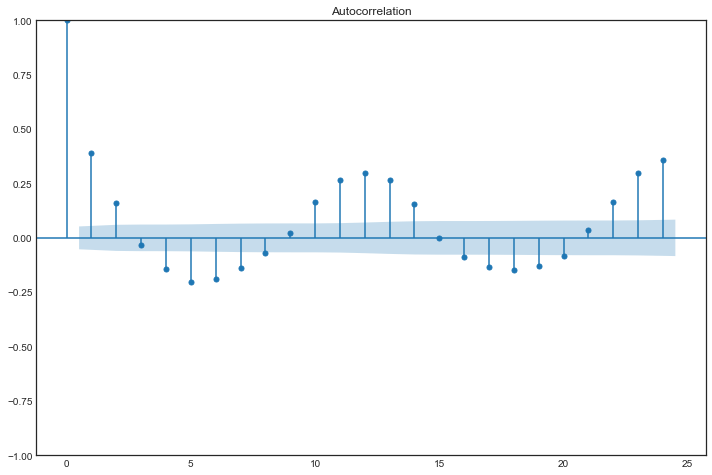

In [45]:
plt.figure(figsize =(10,8))
plot_acf(DecomposeM.resid,lags = 24)
plt.show()

<Figure size 720x576 with 0 Axes>

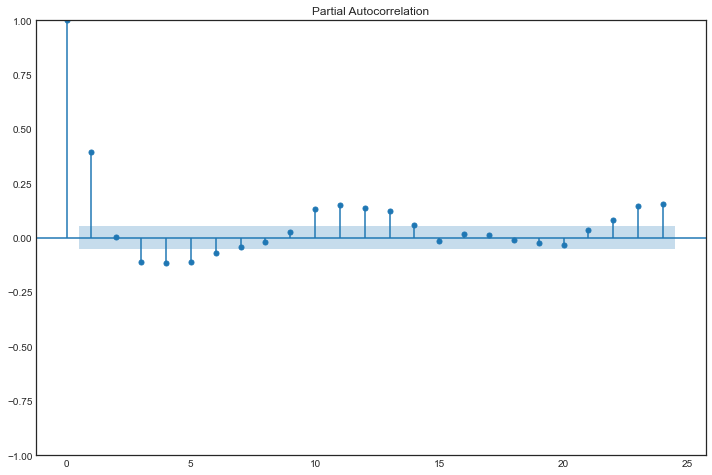

In [46]:
plt.figure(figsize =(10,8))
plot_pacf(DecomposeM.resid,lags = 24)
plt.show()

Many of the spikes in the ACF are outside the boundary. There could a periodic or oscillatory pattern in our dataset. The PACF also shows signs of autocorrelation between the variable and its lagged values. Both the ACF and PACF follow a sin wave pattern.

### 2.c - Comparison

The multiplicative decomposition is better. 

First off, Both ACF plots of additive decomposition and multiplicative decomposition have over 20 significant spikes and display periodic fluctuations. However, in comparison to the PACF plot of additive decomposition, the PACF plot of multiplicative decomposition decay more slowly, which indicates that it's more persistent. Thus, The multiplicative decomposition is better. 


### 2.d - Similarities

The appropiate models for additive and multiplicative decomposition will be different from each other. As we can see from an ACF plot of additive decomposition, only first 6 spikes are signifinicantly different from 0, suggesting that we can model these residuals by using AR6 model. Meanwhile, an ACF plot of multiplicative decomposition shows the signal of some cycles left, we can model these residuals by including some periodic functions such as sine or cosine.  

### 2.e - Seasonal Plot

In [47]:
clim

,LandAverageTemperature,counter,t,Month
dt,,,,
1900-01-01,1.461,0,1,January
1900-02-01,3.098,1,2,February
1900-03-01,5.492,2,3,March
1900-04-01,8.223,3,4,April
1900-05-01,11.385,4,5,May
...,...,...,...,...
2015-08-01,14.755,1387,1388,August
2015-09-01,12.999,1388,1389,September
2015-10-01,10.801,1389,1390,October


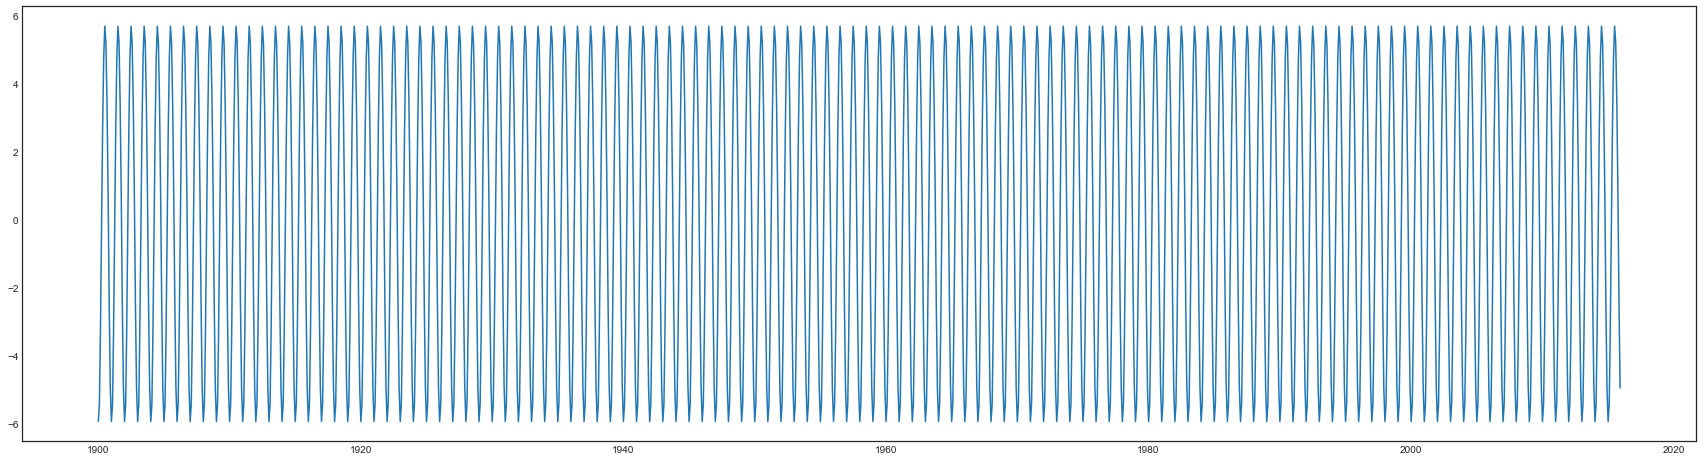

In [59]:
plt.figure(figsize = (30,8))
plt.plot(clim['LandAverageTemperature']-DecomposeA.resid-DecomposeA.trend)

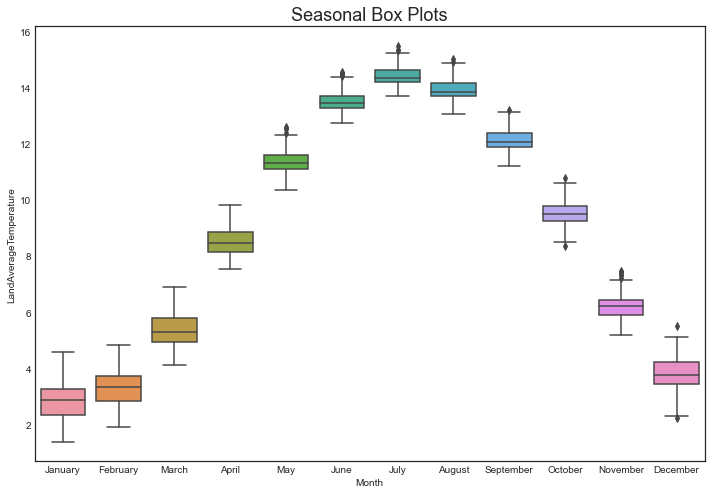

In [49]:
sns.boxplot(x='Month',y='LandAverageTemperature', data = clim)
plt.title('Seasonal Box Plots', fontsize=18); 

Obviously, these boxplots indicate strong seasonal factors of this time series. the series starts with low temperatures around the average of 3 in January which is winter season,and then increases over months until reaching a peak of 14 around July which is summer season in many countries. Right after, the temperatures start to move downward before reaching low temperatures again in December.

### 2.f - Forecast

In [52]:
model_t = smf.ols('LandAverageTemperature~t',data = clim).fit()
model_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     LandAverageTemperature   R-squared:                       0.008
Model:                                OLS   Adj. R-squared:                  0.007
Method:                     Least Squares   F-statistic:                     10.75
Date:                    Sun, 23 Apr 2023   Prob (F-statistic):            0.00107
Time:                            11:33:30   Log-Likelihood:                -3966.9
No. Observations:                    1392   AIC:                             7938.
Df Residuals:                        1390   BIC:                             7948.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1251      0.224     36.196      0.000       7.685       8.565
t              0.0009      0.000      3.278      0.001       0.000       0.001
==============================================================================
Omnibus:                     9718.933   Durbin-Watson:                   0.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.420
Skew:                          -0.071   Prob(JB):                     4.78e-29
Kurtosis:                       1.507   Cond. No.                     1.61e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
model_t2 = smf.ols('LandAverageTemperature~t+I(t**2)',data = clim).fit()
model_t2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     LandAverageTemperature   R-squared:                       0.008
Model:                                OLS   Adj. R-squared:                  0.007
Method:                     Least Squares   F-statistic:                     5.776
Date:                    Sun, 23 Apr 2023   Prob (F-statistic):            0.00318
Time:                            11:34:12   Log-Likelihood:                -3966.5
No. Observations:                    1392   AIC:                             7939.
Df Residuals:                        1389   BIC:                             7955.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.3512      0.337     24.778      0.000       7.690       9.012
t          -5.804e-05      0.001     -0.052      0.959      -0.002       0.002
I(t ** 2)   6.986e-07   7.77e-07      0.899      0.369   -8.25e-07    2.22e-06
==============================================================================
Omnibus:                     9686.811   Durbin-Watson:                   0.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.610
Skew:                          -0.071   Prob(JB):                     4.35e-29
Kurtosis:                       1.506   Cond. No.                     2.61e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.61e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
model_t3 = smf.ols('LandAverageTemperature~t+np.sin(t)+np.cos(t)',data = clim).fit()
model_t3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     LandAverageTemperature   R-squared:                       0.008
Model:                                OLS   Adj. R-squared:                  0.006
Method:                     Least Squares   F-statistic:                     3.579
Date:                    Sun, 23 Apr 2023   Prob (F-statistic):             0.0135
Time:                            11:44:44   Log-Likelihood:                -3966.9
No. Observations:                    1392   AIC:                             7942.
Df Residuals:                        1388   BIC:                             7963.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1251      0.225     36.170      0.000       7.684       8.566
t              0.0009      0.000      3.276      0.001       0.000       0.001
np.sin(t)     -0.0131      0.159     -0.083      0.934      -0.325       0.298
np.cos(t)      0.0028      0.159      0.017      0.986      -0.309       0.314
==============================================================================
Omnibus:                     9718.561   Durbin-Watson:                   0.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.423
Skew:                          -0.071   Prob(JB):                     4.78e-29
Kurtosis:                       1.507   Cond. No.                     1.61e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
clim

,LandAverageTemperature,counter,t,Month
dt,,,,
1900-01-01,1.461,0,1,January
1900-02-01,3.098,1,2,February
1900-03-01,5.492,2,3,March
1900-04-01,8.223,3,4,April
1900-05-01,11.385,4,5,May
...,...,...,...,...
2015-08-01,14.755,1387,1388,August
2015-09-01,12.999,1388,1389,September
2015-10-01,10.801,1389,1390,October


In [63]:
Model_final1 = smf.ols('LandAverageTemperature~t+Month',data=clim).fit()
Model_final1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     LandAverageTemperature   R-squared:                       0.993
Model:                                OLS   Adj. R-squared:                  0.993
Method:                     Least Squares   F-statistic:                 1.607e+04
Date:                    Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                            08:42:22   Log-Likelihood:                -528.80
No. Observations:                    1392   AIC:                             1084.
Df Residuals:                        1379   BIC:                             1152.
Df Model:                              12                                         
Covariance Type:                nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.9182      0.037    214.717      0.000       7.846       7.991
Month[T.August]        5.4182      0.047    116.087      0.000       5.327       5.510
Month[T.December]     -4.7320      0.047   -101.385      0.000      -4.824      -4.640
Month[T.February]     -5.2043      0.047   -111.505      0.000      -5.296      -5.113
Month[T.January]      -5.7191      0.047   -122.534      0.000      -5.811      -5.627
Month[T.July]          5.9096      0.047    126.617      0.000       5.818       6.001
Month[T.June]          5.0015      0.047    107.160      0.000       4.910       5.093
Month[T.March]        -3.1402      0.047    -67.281      0.000      -3.232      -3.049
Month[T.May]           2.8572      0.047     61.217      0.000       2.766       2.949
Month[T.November]     -2.3198      0.047    -49.704      0.000      -2.411      -2.228
Month[T.October]       0.9850      0.047     21.104      0.000       0.893       1.077
Month[T.September]     3.6255      0.047     77.679      0.000       3.534       3.717
t                      0.0009   2.37e-05     37.590      0.000       0.001       0.001
==============================================================================
Omnibus:                        8.340   Durbin-Watson:                   0.976
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               10.788
Skew:                          -0.053   Prob(JB):                      0.00454
Kurtosis:                       3.418   Cond. No.                     1.00e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [64]:
Model_final2 = smf.ols('LandAverageTemperature~t+I(t**2) + Month',data = clim).fit()
Model_final2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     LandAverageTemperature   R-squared:                       0.993
Model:                                OLS   Adj. R-squared:                  0.993
Method:                     Least Squares   F-statistic:                 1.615e+04
Date:                    Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                            08:43:38   Log-Likelihood:                -469.42
No. Observations:                    1392   AIC:                             966.8
Df Residuals:                        1378   BIC:                             1040.
Df Model:                              13                                         
Covariance Type:                nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.1450      0.041    199.402      0.000       8.065       8.225
Month[T.August]        5.4182      0.045    121.103      0.000       5.330       5.506
Month[T.December]     -4.7320      0.045   -105.765      0.000      -4.820      -4.644
Month[T.February]     -5.2043      0.045   -116.323      0.000      -5.292      -5.117
Month[T.January]      -5.7191      0.045   -127.828      0.000      -5.807      -5.631
Month[T.July]          5.9096      0.045    132.087      0.000       5.822       5.997
Month[T.June]          5.0015      0.045    111.790      0.000       4.914       5.089
Month[T.March]        -3.1402      0.045    -70.187      0.000      -3.228      -3.052
Month[T.May]           2.8572      0.045     63.861      0.000       2.769       2.945
Month[T.November]     -2.3198      0.045    -51.851      0.000      -2.408      -2.232
Month[T.October]       0.9850      0.045     22.015      0.000       0.897       1.073
Month[T.September]     3.6255      0.045     81.035      0.000       3.538       3.713
t                  -8.458e-05    9.1e-05     -0.930      0.353      -0.000    9.39e-05
I(t ** 2)           7.005e-07   6.32e-08     11.078      0.000    5.76e-07    8.25e-07
==============================================================================
Omnibus:                       16.076   Durbin-Watson:                   1.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.268
Skew:                          -0.083   Prob(JB):                     5.37e-06
Kurtosis:                       3.625   Cond. No.                     1.08e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
# extract the starting date and the end dat for my forecast horizon
dates = pd.date_range(start = '2016-01-01', end = '2017-01-01', freq = 'MS')

# get the names of each month for the forecast horizon
month = dates.month_name()

# get the trend variable for the forecast horizon, starting at the end of the original
t = np.arange(len(clim['LandAverageTemperature'])+1, len(clim['LandAverageTemperature'])+14)

# put into a format accepted by statsmodels
new_1 = pd.DataFrame({'Month': month, 't':t, 'AverageTemperature' :np.ones(len(month))}, index = dates)
new_1

,Month,t,AverageTemperature
2016-01-01,January,1393,1.0
2016-02-01,February,1394,1.0
2016-03-01,March,1395,1.0
2016-04-01,April,1396,1.0
2016-05-01,May,1397,1.0
2016-06-01,June,1398,1.0
2016-07-01,July,1399,1.0
2016-08-01,August,1400,1.0
2016-09-01,September,1401,1.0
2016-10-01,October,1402,1.0


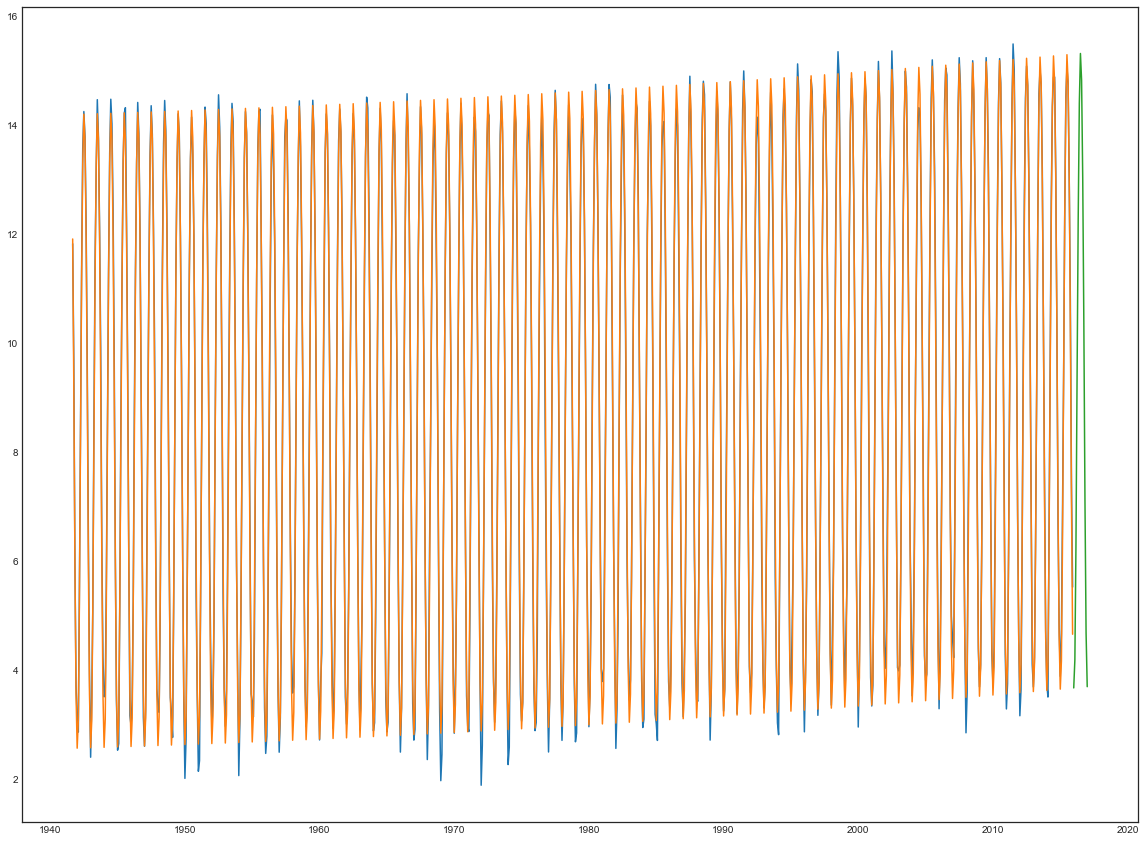

In [72]:
plt.figure(figsize = (20,15))
plt.plot(clim['LandAverageTemperature'][500:])
plt.plot(Model_final2.fittedvalues[500:])
plt.plot(Model_final2.predict(new_1))
plt.show()

## Conclusion

Our final model is estimating the future average temperatures of the earth's land using the trend, trend squared and the seasonality dummies. All of the dummies are significant and the squared term on the trend is significant as well. The R-Squared and adjusted R-Squared are 0.993 which is extremely high, menaing the trend, trend squared and seasonality dummies explain the average land temperature very well. The AIC and BIC are also the lowest out of all the models tested. The forecast suggests the earth's temperature will continue to rise. This implies more melting ice caps, sea levels rising and uninhabitable temperatures for some ocean and land life. Going forward, we can try an AR process since the PACF of the average land temperatures shows almost all spikes outside the boundary. When this happens, an AR process may model the data better.

### References

Kaggle: https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalTemperatures.csv

Professor Rojas's powerpoints and codes

Professor Kunz's powerpoints and codes